In [362]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sts
#from NYT_data_collect import saveFilePath

In [384]:
def getCounty(area_name):
    sub_str = area_name.split(", ")
    if len(sub_str) > 1:
        return sub_str[0].replace(" County","")
    elif "," not in area_name:
        return area_name.replace(" County","")
    else:
        return "not_county"
def getYear(column_name):
    sub_str = column_name.split("_")
    year = sub_str[len(sub_str)-1]
    if type(year) == str:
        try:
            float(year)
            return year
        except ValueError:
            return "no_year"
    else:
        return "no_year"
def removeComma(potential_number):
    if type(potential_number) == int or type(potential_number) == float: return potential_number
    full_str = ""
    for thing in potential_number:
        if thing != "," and thing != "$":
            full_str+=thing
    
    return int(full_str)

In [364]:
file_path = '../../Resources/NYT_counties_data.csv'
NYT_df = pd.read_csv(file_path)
file_path = '../../Resources/UnemploymentUSA.csv'
unemployment_df = pd.read_csv(file_path)
deathSumCounty_df = NYT_df.groupby("county").sum()
county_death_df = pd.read_csv("../../Resources/FINAL_illinois_COVID/county_death_data.csv")
county_confirmed_df = pd.read_csv("../../Resources/FINAL_illinois_COVID/FINAL_illinois_COVID_county.csv")

In [365]:
del county_death_df["total_tested_4_14_2020"]
county_death_df.head()

,Unnamed: 0,county,confirmed_cases_4_14_2020,deaths_4_14_2020
0,0,Illinois,24593,948
1,1,Chicago,10192,361
2,2,Adams,27,0
3,3,Alexander,0,0
4,4,Bond,4,0


In [366]:
unemployment_df["county"] = unemployment_df["Area_name"].map(getCounty)
unemployment_df = unemployment_df.loc[unemployment_df["State"] == "IL"]
unemployment_df.dropna(inplace = True)
#unemployment_df["County_name"].head()
for (columnName, columnData) in unemployment_df.iteritems():
    year = getYear(columnName)
    if year == "no_year":
        continue
    elif float(year) < 2018:
        del unemployment_df[columnName]
unemployment_df.head()

,FIPS,State,Area_name,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Median_Household_Income_2018,Med_HH_Income_Percent_of_State_Total_2018,county
612,17001,IL,"Adams County, IL","32,893","31,616","1,277",3.9,"$55,174",84.8,Adams
613,17003,IL,"Alexander County, IL","2,153","1,982",171,7.9,"$35,249",54.2,Alexander
614,17005,IL,"Bond County, IL","7,929","7,582",347,4.4,"$54,800",84.2,Bond
615,17007,IL,"Boone County, IL","26,473","24,950","1,523",5.8,"$74,507",114.5,Boone
616,17009,IL,"Brown County, IL","2,896","2,818",78,2.7,"$55,327",85.0,Brown


In [367]:
county_total = pd.merge(county_death_df,county_confirmed_df,on="county",suffixes=("",""),how="outer")
county_total = county_total.drop(columns = ["Unnamed: 0"])
county_total = pd.merge(county_total, deathSumCounty_df, on = "county",  suffixes = ("",""), how = "outer")
county_total = county_total.drop(columns = ["Unnamed: 0"])
unemployment_df.drop_duplicates("county", inplace=True)
county_total = pd.merge(county_total,unemployment_df,on="county",suffixes=("",""),how="outer")

#unemployment_df["county"].value_counts
#county_total.head()
county_total.head()

,county,confirmed_cases_4_14_2020,deaths_4_14_2020,<20,20-29,30-39,40-49,50-59,60-69,70-79,...,deaths,FIPS,State,Area_name,Civilian_labor_force_2018,Employed_2018,Unemployed_2018,Unemployment_rate_2018,Median_Household_Income_2018,Med_HH_Income_Percent_of_State_Total_2018
0,Illinois,24593.0,948.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Chicago,10192.0,361.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Adams,27.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,...,126.0,17001.0,IL,"Adams County, IL","32,893","31,616","1,277",3.9,"$55,174",84.8
3,Alexander,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,17003.0,IL,"Alexander County, IL","2,153","1,982",171,7.9,"$35,249",54.2
4,Bond,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,17005.0,IL,"Bond County, IL","7,929","7,582",347,4.4,"$54,800",84.2


In [369]:

for (columnName, columnData) in county_total.iteritems():
    del_or_numeric = input(f"delete (del) or numeric (num) or nothing (n) {columnName}: ")
    while del_or_numeric == "del" or "num" or "nothing":
        if del_or_numeric == "del":
            del county_total[columnName]
            break
        elif del_or_numeric == "num":
#             for index,row in county_total.iterrows():
#                 county_total.at[index, columnName] = removeComma(row[columnName])
            county_total[columnName] = county_total[columnName].map(removeComma)
            county_total[columnName] = pd.to_numeric(county_total[columnName])
            break
        elif del_or_numeric == "n":
            break
        else:
            del_or_numeric = input(f"delete (del) or numeric (num) or nothing (n) {columnName}: ")
        
county_total

delete (del) or numeric (num) or nothing (n) county: n
delete (del) or numeric (num) or nothing (n) confirmed_cases_4_14_2020: num
delete (del) or numeric (num) or nothing (n) deaths_4_14_2020: num
delete (del) or numeric (num) or nothing (n) <20: num
delete (del) or numeric (num) or nothing (n) 20-29: num
delete (del) or numeric (num) or nothing (n) 30-39: num
delete (del) or numeric (num) or nothing (n) 40-49: num
delete (del) or numeric (num) or nothing (n) 50-59: num
delete (del) or numeric (num) or nothing (n) 60-69: num
delete (del) or numeric (num) or nothing (n) 70-79: num
delete (del) or numeric (num) or nothing (n) 80+: num
delete (del) or numeric (num) or nothing (n) White: num
delete (del) or numeric (num) or nothing (n) Black: num
delete (del) or numeric (num) or nothing (n) Left Blank: num
delete (del) or numeric (num) or nothing (n) Other: num
delete (del) or numeric (num) or nothing (n) Asian: num
delete (del) or numeric (num) or nothing (n) Hispanic: num
delete (del) o

,county,confirmed_cases_4_14_2020,deaths_4_14_2020,<20,20-29,30-39,40-49,50-59,60-69,70-79,...,Other,Asian,Hispanic,NH/PI*,AI/AN**,Male,Female,Unknown/Left Blank,Unemployment_rate_2018,Median_Household_Income_2018
0,Illinois,24593.0,948.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Chicago,10192.0,361.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Adams,27.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,3.9,55174.0
3,Alexander,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.9,35249.0
4,Bond,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.4,54800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1584,Young,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1585,Yuba,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1586,Yukon-Koyukuk Census Area,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1587,Yuma,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [370]:
# del county_total["cases"]
# county_total.dropna(inplace=True)

poverty_estimates = pd.read_csv("../../Resources/PovertyEstimates.csv")

In [371]:
poverty_estimates.columns

Index(['FIPStxt', 'Stabr', 'Area_name', 'Rural-urban_Continuum_Code_2003',
       'Urban_Influence_Code_2003', 'Rural-urban_Continuum_Code_2013',
       'Urban_Influence_Code_2013', 'POVALL_2018', 'CI90LBAll_2018',
       'CI90UBALL_2018', 'PCTPOVALL_2018', 'CI90LBALLP_2018',
       'CI90UBALLP_2018', 'POV017_2018', 'CI90LB017_2018', 'CI90UB017_2018',
       'PCTPOV017_2018', 'CI90LB017P_2018', 'CI90UB017P_2018', 'POV517_2018',
       'CI90LB517_2018', 'CI90UB517_2018', 'PCTPOV517_2018', 'CI90LB517P_2018',
       'CI90UB517P_2018', 'MEDHHINC_2018', 'CI90LBINC_2018', 'CI90UBINC_2018',
       'POV04_2018', 'CI90LB04_2018', 'CI90UB04_2018', 'PCTPOV04_2018',
       'CI90LB04P_2018', 'CI90UB04P_2018', 'Unnamed: 34', 'Unnamed: 35',
       'Unnamed: 36', 'Unnamed: 37', 'Unnamed: 38', 'Unnamed: 39',
       'Unnamed: 40', 'Unnamed: 41', 'Unnamed: 42', 'Unnamed: 43',
       'Unnamed: 44', 'Unnamed: 45', 'Unnamed: 46'],
      dtype='object')

In [372]:
for (column_name, column_data) in poverty_estimates.iteritems():
    if "Unnamed" in column_name:
        del poverty_estimates[column_name]
poverty_estimates.head()

,FIPStxt,Stabr,Area_name,Rural-urban_Continuum_Code_2003,Urban_Influence_Code_2003,Rural-urban_Continuum_Code_2013,Urban_Influence_Code_2013,POVALL_2018,CI90LBAll_2018,CI90UBALL_2018,...,CI90UB517P_2018,MEDHHINC_2018,CI90LBINC_2018,CI90UBINC_2018,POV04_2018,CI90LB04_2018,CI90UB04_2018,PCTPOV04_2018,CI90LB04P_2018,CI90UB04P_2018
0,0,US,United States,NaN,NaN,NaN,NaN,"41,852,315","41,619,366","42,085,264",...,17.2,"61,937","61,843","62,031","3,758,704","3,714,862","3,802,546",19.5,19.3,19.7
1,1000,AL,Alabama,NaN,NaN,NaN,NaN,"801,758","785,668","817,848",...,23.7,"49,881","49,123","50,639","73,915","69,990","77,840",26.0,24.6,27.4
2,1001,AL,Autauga County,2.0,2.0,2.0,2.0,"7,587","6,334","8,840",...,23.9,"59,338","53,628","65,048",NaN,NaN,NaN,NaN,NaN,NaN
3,1003,AL,Baldwin County,4.0,5.0,3.0,2.0,"21,069","17,390","24,748",...,16.9,"57,588","54,437","60,739",NaN,NaN,NaN,NaN,NaN,NaN
4,1005,AL,Barbour County,6.0,6.0,6.0,6.0,"6,788","5,662","7,914",...,45.9,"34,382","31,157","37,607",NaN,NaN,NaN,NaN,NaN,NaN


In [373]:
for (columnName, columnData) in poverty_estimates.iteritems():
    are_you_sure = input(f"Would you like {columnName} to be renamed?")
    if are_you_sure == "yes":
        new_column_name = input(f"What would you like {columnName} to be renamed?")
    del_or_numeric = input(f"delete (del) or numeric (num) or nothing (n) {columnName}: ")
    while del_or_numeric == "del" or "num" or "nothing":
        if del_or_numeric == "del":
            del poverty_estimates[columnName]
            break
        elif del_or_numeric == "num":
#             for index,row in county_total.iterrows():
#                 county_total.at[index, columnName] = removeComma(row[columnName])
            poverty_estimates[columnName] = poverty_estimates[columnName].map(removeComma)
            poverty_estimates[columnName] = pd.to_numeric(poverty_estimates[columnName])
        
            if are_you_sure == "yes":
                poverty_estimates.rename(columns={columnName:new_column_name},inplace=True)
                    
            break
        elif del_or_numeric == "n":
            
            if are_you_sure == "yes":
                poverty_estimates.rename(columns={columnName:new_column_name},inplace=True)
                
            break
        else:
            del_or_numeric = input(f"delete (del) or numeric (num) or nothing (n) {columnName}: ")
poverty_estimates.head()

Would you like FIPStxt to be renamed?n
delete (del) or numeric (num) or nothing (n) FIPStxt: del
Would you like Stabr to be renamed?n
delete (del) or numeric (num) or nothing (n) Stabr: del
Would you like Area_name to be renamed?n
delete (del) or numeric (num) or nothing (n) Area_name: n
Would you like Rural-urban_Continuum_Code_2003 to be renamed?d
delete (del) or numeric (num) or nothing (n) Rural-urban_Continuum_Code_2003: del
Would you like Urban_Influence_Code_2003 to be renamed?n
delete (del) or numeric (num) or nothing (n) Urban_Influence_Code_2003: del
Would you like Rural-urban_Continuum_Code_2013 to be renamed?d
delete (del) or numeric (num) or nothing (n) Rural-urban_Continuum_Code_2013: del
Would you like Urban_Influence_Code_2013 to be renamed?d
delete (del) or numeric (num) or nothing (n) Urban_Influence_Code_2013: del
Would you like POVALL_2018 to be renamed?yes
What would you like POVALL_2018 to be renamed?all_ages_poverty_2018
delete (del) or numeric (num) or nothing (

,Area_name,all_ages_poverty_2018,all_ages_poverty_rate_2018,median_HH_2018
0,United States,"41,852,315",13.1,61937
1,Alabama,"801,758",16.8,49881
2,Autauga County,"7,587",13.8,59338
3,Baldwin County,"21,069",9.8,57588
4,Barbour County,"6,788",30.9,34382


In [374]:
poverty_estimates.head()

,Area_name,all_ages_poverty_2018,all_ages_poverty_rate_2018,median_HH_2018
0,United States,"41,852,315",13.1,61937
1,Alabama,"801,758",16.8,49881
2,Autauga County,"7,587",13.8,59338
3,Baldwin County,"21,069",9.8,57588
4,Barbour County,"6,788",30.9,34382


In [375]:
poverty_estimates.to_csv("../../Resources/poverty_FINAL.csv")
poverty_final = pd.read_csv("../../Resources/poverty_FINAL.csv")

In [377]:
county_total

,county,confirmed_cases_4_14_2020,deaths_4_14_2020,<20,20-29,30-39,40-49,50-59,60-69,70-79,...,AI/AN**,Male,Female,Unknown/Left Blank,Unemployment_rate_2018,Median_Household_Income_2018,Area_name,all_ages_poverty_2018,all_ages_poverty_rate_2018,median_HH_2018


In [386]:
poverty_estimates["county"] = poverty_estimates["Area_name"].map(getCounty)
county_final = pd.merge(county_final,poverty_estimates,on="county",how="inner")
county_final

,Unnamed: 0,Unnamed: 0.1,county,confirmed_cases_4_14_2020,deaths_4_14_2020,<20,20-29,30-39,40-49,50-59,...,Female,Unknown/Left Blank,State,Unemployment_rate_2018,Median_Household_Income_2018,Med_HH_Income_Percent_of_State_Total_2018,Area_name,all_ages_poverty_2018,all_ages_poverty_rate_2018,median_HH_2018
0,0,2,Adams,27.0,0.0,0.0,0.0,0.0,0.0,6.0,...,0.0,0.0,IL,3.9,55174.0,84.8,Adams County,"46,711",9.2,70199
1,0,2,Adams,27.0,0.0,0.0,0.0,0.0,0.0,6.0,...,0.0,0.0,IL,3.9,55174.0,84.8,Adams County,554,13.2,45311
2,0,2,Adams,27.0,0.0,0.0,0.0,0.0,0.0,6.0,...,0.0,0.0,IL,3.9,55174.0,84.8,Adams County,"7,803",12.3,55174
3,0,2,Adams,27.0,0.0,0.0,0.0,0.0,0.0,6.0,...,0.0,0.0,IL,3.9,55174.0,84.8,Adams County,"4,056",11.6,56693
4,0,2,Adams,27.0,0.0,0.0,0.0,0.0,0.0,6.0,...,0.0,0.0,IL,3.9,55174.0,84.8,Adams County,460,12.7,51577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,37,102,Williamson,12.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,IL,5.1,46187.0,71.0,Williamson County,"8,794",3.8,115930
235,37,102,Williamson,12.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,IL,5.1,46187.0,71.0,Williamson County,"35,829",6.4,87817
236,38,103,Winnebago,112.0,4.0,0.0,0.0,0.0,0.0,6.0,...,33.0,0.0,IL,5.7,53795.0,82.7,Winnebago County,"45,006",16.1,53795
237,38,103,Winnebago,112.0,4.0,0.0,0.0,0.0,0.0,6.0,...,33.0,0.0,IL,5.7,53795.0,82.7,Winnebago County,912,9.1,54433


In [381]:
# county_total.to_csv("../../Resources/FULL_ILLINOIS_COUNTY_DATA.csv")
county_final = pd.read_csv("../../Resources/FULL_ILLINOIS_COUNTY_DATA.csv")

In [387]:
county_final.to_csv("../../Resources/FULL_ILLINOIS_COUNTY_DATA.csv")

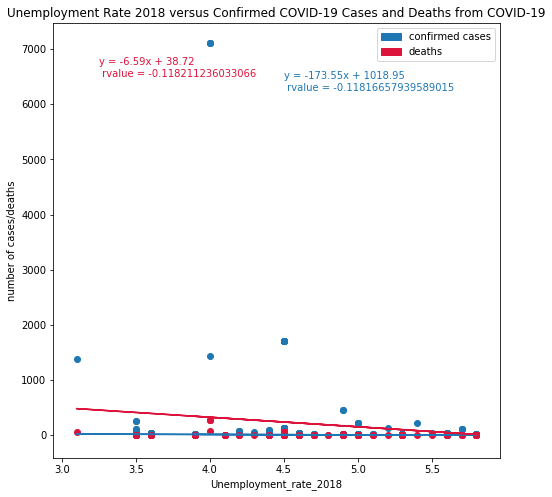

In [405]:
#constants
xvalues = county_final["Unemployment_rate_2018"]

#figure adjustments
plt.figure(figsize=(8,8))

#confirmed cases portion of chart
cyvalues = county_final["confirmed_cases_4_14_2020"]
(cslope, cintercept, crvalue, cpvalue, cstderr) = sts.linregress(xvalues, cyvalues)
cregress_values = xvalues * cslope + cintercept
cline_eq = "y = " + str(round(cslope,2)) + "x + " + str(round(cintercept,2))

#death portion of chart
dyvalues = county_final["deaths_4_14_2020"]
(dslope, dintercept, drvalue, dpvalue, dstderr) = sts.linregress(xvalues, dyvalues)
dregress_values = xvalues * dslope + dintercept
dline_eq = "y = " + str(round(dslope,2)) + "x + " + str(round(dintercept,2))

#legend stuff
colors = {'confirmed cases':'C0', 'deaths':'crimson'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

#actual scatter plots
plt.scatter(x=xvalues,y=cyvalues,color='C0',)
plt.scatter(x=xvalues,y=dyvalues,color='crimson')
plt.plot(xvalues,dregress_values,"r-",color='C0')
plt.annotate(dline_eq+f"\n rvalue = {drvalue}",(3.25,6500),fontsize=10,color="crimson")
plt.plot(xvalues,cregress_values,"r-",color="crimson")
plt.annotate(cline_eq+f"\n rvalue = {crvalue}",(4.5,6250),fontsize=10,color="C0")

#chart labels
plt.xlabel('Unemployment_rate_2018')
plt.ylabel('number of cases/deaths')
plt.title('Unemployment Rate 2018 versus Confirmed COVID-19 Cases and Deaths from COVID-19')
plt.savefig('unemployment_rate.png',dpi=125,edgecolor='black',format='png',transparent=False)
plt.show()

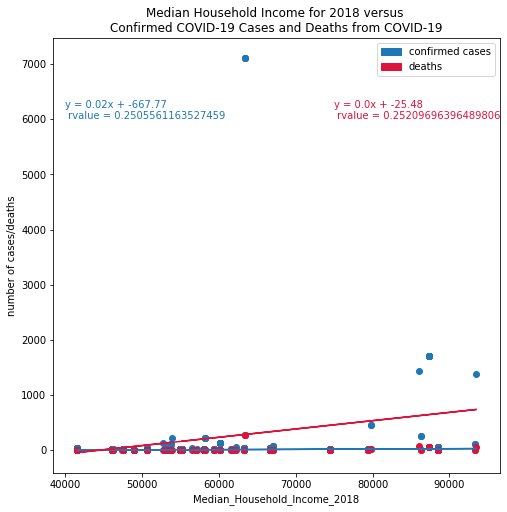

In [409]:

#constants
xvalues = county_final["Median_Household_Income_2018"]

#figure adjustments
plt.figure(figsize=(8,8))

#confirmed cases portion of chart
cyvalues = county_final["confirmed_cases_4_14_2020"]
(cslope, cintercept, crvalue, cpvalue, cstderr) = sts.linregress(xvalues, cyvalues)
cregress_values = xvalues * cslope + cintercept
cline_eq = "y = " + str(round(cslope,2)) + "x + " + str(round(cintercept,2))

#death portion of chart
dyvalues = county_final["deaths_4_14_2020"]
(dslope, dintercept, drvalue, dpvalue, dstderr) = sts.linregress(xvalues, dyvalues)
dregress_values = xvalues * dslope + dintercept
dline_eq = "y = " + str(round(dslope,2)) + "x + " + str(round(dintercept,2))

#legend stuff
colors = {'confirmed cases':'C0', 'deaths':'crimson'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

#actual scatter plots
plt.scatter(x=xvalues,y=cyvalues,color='C0',)
plt.scatter(x=xvalues,y=dyvalues,color='crimson')
plt.plot(xvalues,dregress_values,"r-",color='C0')
plt.annotate(dline_eq+f"\n rvalue = {drvalue}",(75000,6000),fontsize=10,color="crimson")
plt.plot(xvalues,cregress_values,"r-",color="crimson")
plt.annotate(cline_eq+f"\n rvalue = {crvalue}",(40000,6000),fontsize=10,color="C0")

#chart labels
plt.xlabel('Median_Household_Income_2018')
plt.ylabel('number of cases/deaths')
plt.title('Median Household Income for 2018 versus \nConfirmed COVID-19 Cases and Deaths from COVID-19')
plt.savefig('medianHH.png',dpi=125,edgecolor='black',format='png',transparent=False)
plt.show()

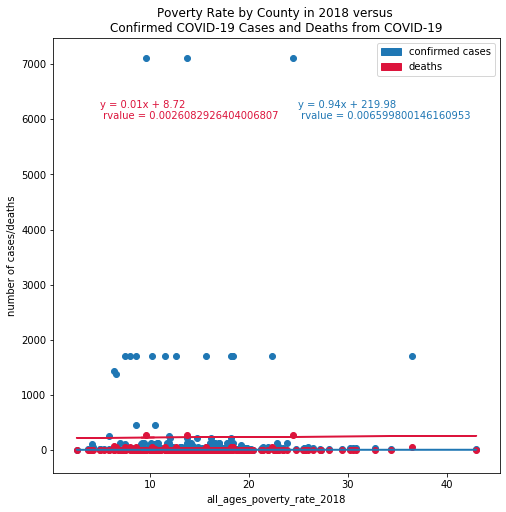

In [410]:

#constants
xvalues = county_final["all_ages_poverty_rate_2018"]

#figure adjustments
plt.figure(figsize=(8,8))

#confirmed cases portion of chart
cyvalues = county_final["confirmed_cases_4_14_2020"]
(cslope, cintercept, crvalue, cpvalue, cstderr) = sts.linregress(xvalues, cyvalues)
cregress_values = xvalues * cslope + cintercept
cline_eq = "y = " + str(round(cslope,2)) + "x + " + str(round(cintercept,2))

#death portion of chart
dyvalues = county_final["deaths_4_14_2020"]
(dslope, dintercept, drvalue, dpvalue, dstderr) = sts.linregress(xvalues, dyvalues)
dregress_values = xvalues * dslope + dintercept
dline_eq = "y = " + str(round(dslope,2)) + "x + " + str(round(dintercept,2))

#legend stuff
colors = {'confirmed cases':'C0', 'deaths':'crimson'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

#actual scatter plots
plt.scatter(x=xvalues,y=cyvalues,color='C0',)
plt.scatter(x=xvalues,y=dyvalues,color='crimson')
plt.plot(xvalues,dregress_values,"r-",color='C0')
plt.annotate(dline_eq+f"\n rvalue = {drvalue}",(5,6000),fontsize=10,color="crimson")
plt.plot(xvalues,cregress_values,"r-",color="crimson")
plt.annotate(cline_eq+f"\n rvalue = {crvalue}",(25,6000),fontsize=10,color="C0")

#chart labels
plt.xlabel('all_ages_poverty_rate_2018')
plt.ylabel('number of cases/deaths')
plt.title('Poverty Rate by County in 2018 versus \nConfirmed COVID-19 Cases and Deaths from COVID-19')
plt.savefig('poverty_rate.png',dpi=125,edgecolor='black',format='png',transparent=False)
plt.show()